In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import utils
import matplotlib.pyplot as plt

### (1) Load Artifacts

In [3]:
user_id_map_dict = utils.open_object("./artifacts/user_id_map_dict.pkl")
movie_id_map_dict = utils.open_object("./artifacts/movie_id_map_dict.pkl")
genres_map_dict = utils.open_object("./artifacts/genres_map_dict.pkl")

In [4]:
num_user = len(user_id_map_dict)
num_movie = len(movie_id_map_dict)
num_genre = len(genres_map_dict)

### (2) Modeling

In [5]:
config_dict={}

In [6]:
config_dict={}
config_dict['num_user'] = num_user 
config_dict['num_item'] = num_movie 
config_dict['num_genre'] = num_genre
config_dict['latent_dim_mlp'] =  64
config_dict['latent_dim_mf']=config_dict['latent_dim_mlp']
config_dict['layers'] = [config_dict['latent_dim_mf']*3]+[64,32]
config_dict['num_layers'] = len(config_dict['layers'])
config_dict['dropout_rate_mf']=0.6
config_dict['dropout_rate_mlp']=0.6
config_dict['batch_size']=32
config_dict['epoches']=8
config_dict['eval_steps']=500
config_dict['use_xavier_uniform']=False
config_dict['learning_rate']=0.001

In [7]:
class Config:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            setattr(self, key, value)

In [8]:
config = Config(dictionary=config_dict)

In [30]:
%%writefile model.py

import torch

class NeuMF(torch.nn.Module):
    def __init__(self, config):
        super(NeuMF, self).__init__()
        self.config = config

        # matrix factorization part
        self.embedding_user_mf = torch.nn.Embedding(
            num_embeddings=self.config.num_user, embedding_dim=self.config.latent_dim_mf)
        if self.config.use_xavier_uniform:
            torch.nn.init.xavier_uniform_(self.embedding_user_mf.weight)

        self.embedding_item_mf = torch.nn.Embedding(
            num_embeddings=self.config.num_item, embedding_dim=self.config.latent_dim_mf)
        if self.config.use_xavier_uniform:
            torch.nn.init.xavier_uniform_(self.embedding_item_mf.weight)

        self.embedding_genre_mf = torch.nn.Embedding(
            num_embeddings=self.config.num_genre, embedding_dim=self.config.latent_dim_mf)
        if self.config.use_xavier_uniform:
            torch.nn.init.xavier_uniform_(self.embedding_genre_mf.weight)


        # multilayer perceptron part
        self.embedding_user_mlp = torch.nn.Embedding(
            num_embeddings=self.config.num_user, embedding_dim=self.config.latent_dim_mlp)
        if self.config.use_xavier_uniform:
            torch.nn.init.xavier_uniform_(self.embedding_user_mlp.weight)

        self.embedding_item_mlp = torch.nn.Embedding(
            num_embeddings=self.config.num_item, embedding_dim=self.config.latent_dim_mlp)
        if self.config.use_xavier_uniform:
            torch.nn.init.xavier_uniform_(self.embedding_item_mlp.weight)

        self.embedding_genre_mlp = torch.nn.Embedding(
            num_embeddings=self.config.num_genre, embedding_dim=self.config.latent_dim_mlp)
        if self.config.use_xavier_uniform:
            torch.nn.init.xavier_uniform_(self.embedding_genre_mlp.weight)

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.config.layers[:-1], self.config.layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.logits = torch.nn.Linear(
            in_features=self.config.layers[-1] + self.config.latent_dim_mf, out_features=1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, user_indices, item_indices,genre_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        genre_embedding_mlp = self.embedding_genre_mlp(genre_indices)
        genre_embedding_mlp = torch.mean(genre_embedding_mlp,axis=1)

        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)
        genre_embedding_mf = self.embedding_genre_mf(genre_indices)
        genre_embedding_mf = torch.max(genre_embedding_mf,axis=1)[0]


        # mf part: element-wise product
        mf_vector = torch.mul(item_embedding_mf, genre_embedding_mf)
        mf_vector = torch.nn.Dropout(self.config.dropout_rate_mf)(mf_vector)

        mf_vector = torch.mul(user_embedding_mf, mf_vector)
        mf_vector = torch.nn.Dropout(self.config.dropout_rate_mf)(mf_vector)

        # mlp part
        # the concat latent vector
        mlp_vector = torch.cat(
            [user_embedding_mlp, item_embedding_mlp,genre_embedding_mlp], dim=-1)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            """
            1) The sigmoid function restricts each
            neuron to be in (0,1), which may limit the model's perfor-
            mance; and it is known to suffer from saturation, where
            neurons stop learning when their output is near either 0 or
            1. 2) Even though tanh is a better choice and has been
            widely adopted [6, 44], it only alleviates the issues of sig-
            moid to a certain extent, since it can be seen as a rescaled
            version of sigmoid. And 3) as
            such, we opt for ReLU, which is more biologically plausi-
            ble and proven to be non-saturated [9]; moreover, it encour-
            ages sparse activations, being well-suited for sparse data and
            making the model less likely to be overfitting. Our empirical
            results show that ReLU yields slightly better performance
            than tanh, which in turn is significantly better than sigmoid.
            """
            mlp_vector = torch.nn.ReLU()(mlp_vector)

        mlp_vector = torch.nn.Dropout(self.config.dropout_rate_mlp)(mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.logits(vector)
        output = self.sigmoid(logits)
        return output

Overwriting model.py


In [10]:
from model import NeuMF

## (3) Load Processed Data

In [11]:
df_processed = pd.read_parquet("./data/processed.parquet")

(array([1.6414e+04, 2.8562e+04, 3.1889e+04, 1.6701e+04, 5.5190e+03,
        1.3880e+03, 3.6000e+02, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

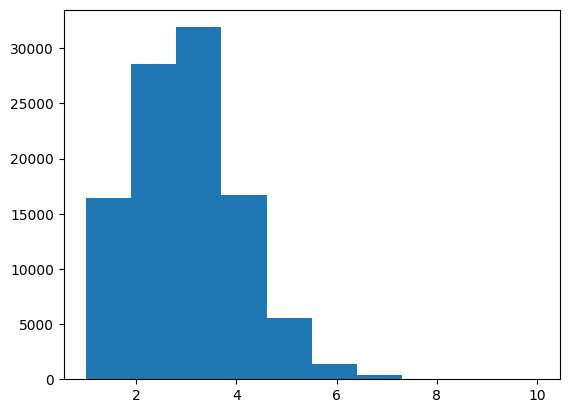

In [12]:
plt.hist([ len(x) for x in df_processed['genres_embed_ids']])

In [13]:
# max_genres = max([ len(x) for x in df_processed['genres_embed_ids']])
max_genres = 5

In [14]:
%%writefile dataset.py
import torch
from torch.utils.data import Dataset
# from torch.nn.utils.rnn import pad_sequence


class RatingDataset(Dataset):
    def __init__(self, data, max_genres=5):
        self.data = data
        self.max_genres = max_genres

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        
        data_item = self.data.iloc[index]
        
        user_embed_id = data_item["user_embed_id"]
        movie_embed_id = data_item["movie_embed_id"]
        genres_embed_ids = data_item["genres_embed_ids"].tolist()
        genres_embed_ids = genres_embed_ids+[0]* self.max_genres
        genres_embed_ids = genres_embed_ids[:self.max_genres]
        # genres_embed_ids = [torch.tensor(ids) for ids in genres_embed_ids]
        # padded_genres_embed_ids = pad_sequence(
        #     genres_embed_ids, batch_first=True, padding_value=0)
        
        # padded_genres_embed_ids = padded_genres_embed_ids[:, :self.max_genres]

        rating = data_item["rating"]

        sample = {
            "user_embed_id": torch.tensor(user_embed_id, dtype=torch.long),
            "movie_embed_id": torch.tensor(movie_embed_id, dtype=torch.long),
            "genres_embed_ids": torch.tensor(genres_embed_ids, dtype=torch.long),
            "rating": torch.tensor(rating, dtype=torch.float),
        }

        return sample

Overwriting dataset.py


In [15]:
from dataset import RatingDataset

In [16]:
df = pd.read_parquet("./data/processed.parquet")

In [17]:
train_dataset = RatingDataset(data=df,max_genres=5)

In [18]:
# train_dataset[:4]

In [19]:
from torch.utils.data import DataLoader

In [20]:
loader = DataLoader(train_dataset,batch_size=12,shuffle=True)

In [21]:
for sample in loader:
    break

In [27]:
import torch

In [29]:
torch.max(sample['genres_embed_ids'],axis=1)[0]

tensor([14, 17, 17, 18, 16, 15, 18, 19, 16,  9, 18,  7])

In [23]:
recommender = NeuMF(config=config)

In [24]:
sample

{'user_embed_id': tensor([ 33,  51, 318, 107, 610,   7, 570,  89,  50, 580, 182, 263]),
 'movie_embed_id': tensor([1780,  742,  182,   17, 3154,  402, 1051, 1119, 1916,  604, 1026, 1100]),
 'genres_embed_ids': tensor([[ 4,  5, 10, 14,  0],
         [ 9, 17,  0,  0,  0],
         [ 3,  4,  5,  9, 17],
         [ 6,  7,  9, 18,  0],
         [ 3,  6, 10, 16,  0],
         [ 9, 12, 15,  0,  0],
         [ 2,  3,  9, 17, 18],
         [ 6, 19,  0,  0,  0],
         [ 7,  9, 16,  0,  0],
         [ 9,  0,  0,  0,  0],
         [ 6, 18,  0,  0,  0],
         [ 4,  5,  6,  7,  0]]),
 'rating': tensor([0.5556, 1.0000, 0.6667, 0.5556, 0.7778, 0.8889, 0.7778, 0.3333, 0.4444,
         0.7778, 0.3333, 1.0000])}

In [25]:
recommender(user_indices=sample['user_embed_id'],
            item_indices=sample['movie_embed_id'],
            genre_indices=sample['genres_embed_ids'])

tensor([[0.4349],
        [0.4531],
        [0.5740],
        [0.2962],
        [0.4138],
        [0.5603],
        [0.4612],
        [0.4611],
        [0.3741],
        [0.4891],
        [0.5101],
        [0.5583]], grad_fn=<SigmoidBackward0>)